In [7]:
pip install pytorch-ignite

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist


random.seed(999)
torch.manual_seed(999)
torch.use_deterministic_algorithms(False)

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

WORKERS = 2

BATCH_SIZE = 128

IMAGE_SIZE = 64

# Input Channels
n_channels = 3

# Latent Vector Size --> n-dimensional space from where random inputs are drawn from for the Generator
n_z = 100

# Number of Feature Maps/Channels for Generator
ngf = 64

# Number of Feature Maps/Channels for Discriminator
ngd = 64

# Learning rate for optimizers
lr = [0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.1]

# Beta 1 value for the Adam optimizer --> Controls how much of the previous running averages (1st Moment) are kept in current calculation
b1 = 0.0

# Beta 2 value for the Adam optimizer --> Controls how much of the squared previous running averages (2nd Moment) are kept in current calculation
b2 = 0.9

# Training Epochs
epochs = 10

# Number of times Discriminator's loss calculation is taken per iter
n_critic = 5

# Number of iterations per epoch
n_iters = 10000

ModuleNotFoundError: No module named 'kagglehub'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

full_dataset = datasets.ImageFolder(
    root=path,
    train=True,
    download=True,
    transform=transform
)

train_dataset = torch.utils.data.Subset(full_dataset, torch.arange(7000))

test_dataset = torch.utils.data.Subset(full_dataset, torch.arange(7000, 10000))

NameError: name 'transforms' is not defined

In [3]:
train_dataloader = idist.auto_dataloader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    drop_last=True
)

test_dataloader = idist.auto_dataloader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    drop_last=True
)


real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

NameError: name 'idist' is not defined

### Defining the Generator Class and Model Architecture

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=n_z, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    # Forward Loop of the Generator
    def forward(self, input):
        return self.model(input)

In [8]:
# Instantiating Generator
G = idist.auto_model(Generator())
G.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

### Defining the Discriminator Class and Model Architecture

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, input):
        rtn = self.model(input)
        return torch.flatten(rtn)

In [10]:
# Instantiating Discriminator
D = idist.auto_model(Discriminator())
D.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [11]:
# Initializing Optimizers to Use

optim_D = idist.auto_optim((torch.optim.Adam(D.parameters(), lr=lr[2], betas=(b1, b2))))
optim_G = idist.auto_optim((torch.optim.Adam(G.parameters(), lr=lr[2], betas=(b1, b2))))

### Training Loop

In [12]:
###################################################################
# Gradient Penalty Calculation for the Wasserstein Loss Calculation
###################################################################

def calculate_gradient_penalty(model, real_images, fake_images, device):
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [13]:
##############################################
# Start of Training Loop
##############################################
fixed_noise = torch.randn(BATCH_SIZE, n_z, 1, 1, device=device)

def training_step(engine, data):
    img_list = []
    D.train()
    G.train()
    
    for i in range(n_critic):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, n_z, 1, 1, device=device)

        ##############################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ##############################################
        # Set discriminator gradients to zero.
        D.zero_grad()

        # Train with real
        real_output = D(real_images)
        errD_real = torch.mean(real_output)
        D_x = real_output.mean().item()

        # Generate fake image batch with G
        fake_images = G(noise)

        # Train with fake
        fake_output = D(fake_images.detach())
        errD_fake = torch.mean(fake_output)
        D_G_z1 = fake_output.mean().item()
        
        # Calculate W-div gradient penalty
        gradient_penalty = calculate_gradient_penalty(model=D, real_images=real_images.data, fake_images=fake_images.data, device=device)
        # print("  ↳ gradient_penalty =", gradient_penalty.item())

        # Add the gradients from the all-real and all-fake batches
        errD = -errD_real + errD_fake + gradient_penalty * 10
        errD.backward()
        # Update D
        optim_D.step()

    # Train the generator every n_critic iterations
    ##############################################
    # (2) Update G network: maximize log(D(G(z)))
    ##############################################
    # Set generator gradients to zero
    G.zero_grad()

    # Generate fake image batch with G
    fake_images = G(noise)
    fake_output = D(fake_images)
    errG = -torch.mean(fake_output)
    D_G_z2 = fake_output.mean().item()
    errG.backward()
    optim_G.step()

    # progress_bar.set_description(f"[{epoch + 1}/{epochs}][{i + 1}/{len(dataloader)}] "
    #                                 f"Loss_D: {errD.item():.6f} Loss_G: {errG.item():.6f} "
    #                                 f"D(x): {D_x:.6f} D(G(z)): {D_G_z1:.6f}/{D_G_z2:.6f}")
    
    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": D_x,
        "D_G_z1": D_G_z1,
        "D_G_z2": D_G_z2,
    }

        # iters = i + epoch * len(dataloader) + 1

        # # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 250 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = G(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # if iters == int(n_iters):  # If the iteration is reached, exit.
        #     break

### Creating the Pytorch-Ignite Engine for Training

In [14]:
trainer = Engine(training_step)

In [15]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(model.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        if hasattr(model, 'bias') and model.bias is not None:
            nn.init.constant_(model.bias, 0.0)
            
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(model.weight, 1.0)
        nn.init.constant_(model.bias, 0.0)

### Creating Event Functions for the Engine

In [16]:
# Initializes the Weights
@trainer.on(Events.STARTED)
def init_weights():
    D.apply(initialize_weights)
    G.apply(initialize_weights)

In [17]:
G_losses = []
D_losses = []

# Stores the losses after each iteration
@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    out = engine.state.output
    G_losses.append(out['Loss_G'])
    D_losses.append(out['Loss_D'])


In [18]:
img_list = []

# Stores images after each iteration completed
@trainer.on(Events.ITERATION_COMPLETED(every=30))
def store_images(engine):
    with torch.no_grad():
        generated = G(fixed_noise).cpu()
    img_list.append(generated)

### Defining the Fréchet Inception Distance and Inception Score Metrics

In [19]:
from ignite.metrics import FID, InceptionScore

# Fréchet Inception Distance
fid = FID(device=device)

# Inception Score
IS = InceptionScore(device=device, output_transform=lambda x: x[0])

### Resizing Images for InceptionV3 model (used by FID and IS metrics)

In [20]:
import PIL.Image as Image

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [21]:
def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(BATCH_SIZE, n_z, 1, 1, device=device)
        G.eval()
        fake = G(noise)
        fake = interpolate(fake)
        real = interpolate(batch[0])
        
        return fake, real

### Defining the Evaluator Engine

In [22]:
evaluator = Engine(evaluation_step)
fid.attach(evaluator, "FID")
IS.attach(evaluator, "IS")

### Creating Function to Log Training Results

In [23]:
fid_values = []
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def training_results(engine):
    print(f"Epoch [{engine.state.epoch}/100] Metric Scores")

In [24]:
from ignite.metrics import RunningAverage

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [25]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer, metric_names=['Loss_G', 'Loss_D'])
ProgressBar().attach(evaluator)

/home/athimmaudayakumar/.local/lib/python3.11/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### The Training Call Function

In [26]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=100)
    evaluator.run(test_dataloader, max_epochs=1)
    eval_metrics = evaluator.state.metrics
    fid_score = eval_metrics["FID"]
    is_score = eval_metrics["IS"]
    print(f"FID Score: {fid_score}")
    print(f"IS Score: {is_score}")

In [27]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2025-06-04 19:54:31,216 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2025-06-04 19:54:31,217 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7fd3eeb16020>' in 1 processes


[1/54]   2%|1          [00:00<?]

Epoch [1/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [2/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [3/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [4/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [5/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [6/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [7/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [8/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [9/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [10/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [11/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [12/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [13/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [14/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [15/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [16/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [17/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [18/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [19/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [20/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [21/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [22/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [23/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [24/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [25/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [26/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [27/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [28/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [29/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [30/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [31/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [32/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [33/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [34/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [35/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [36/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [37/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [38/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [39/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [40/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [41/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [42/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [43/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [44/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [45/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [46/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [47/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [48/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [49/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [50/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [51/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [52/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [53/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [54/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [55/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [56/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [57/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [58/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [59/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [60/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [61/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [62/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [63/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [64/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [65/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [66/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [67/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [68/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [69/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [70/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [71/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [72/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [73/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [74/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [75/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [76/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [77/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [78/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [79/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [80/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [81/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [82/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [83/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [84/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [85/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [86/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [87/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [88/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [89/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [90/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [91/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [92/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [93/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [94/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [95/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [96/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [97/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [98/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [99/100] Metric Scores


[1/54]   2%|1          [00:00<?]

Epoch [100/100] Metric Scores


[1/23]   4%|4          [00:00<?]

2025-06-04 20:44:13,056 ignite.distributed.launcher.Parallel INFO: End of run
2025-06-04 20:44:13,057 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


FID Score: 0.03912210310297484
IS Score: 1.8592499473309376


### Results

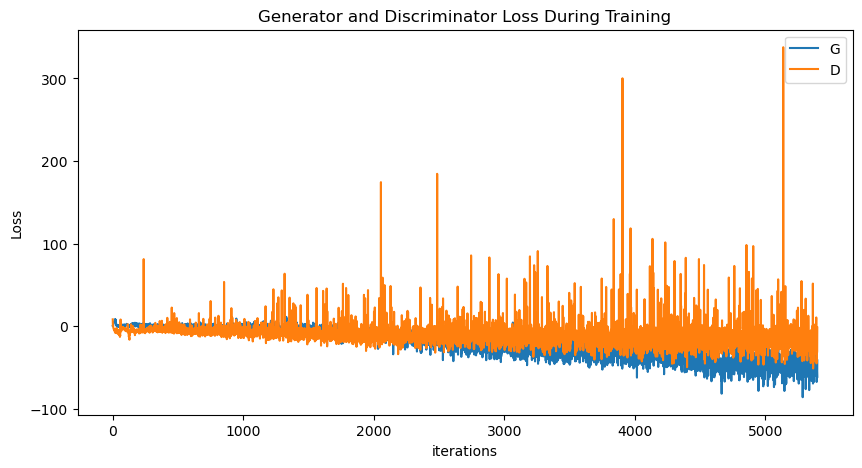

In [28]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

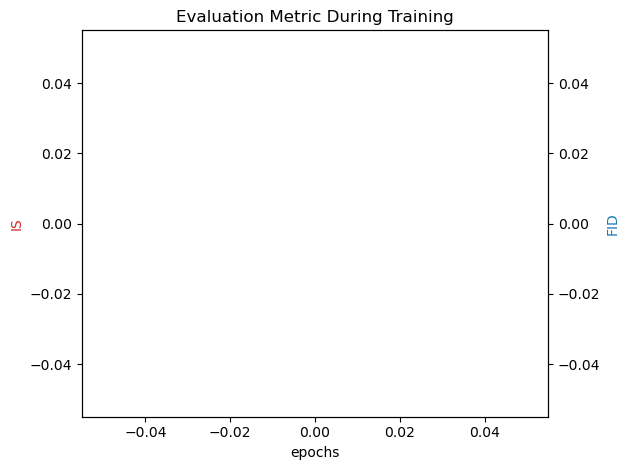

In [29]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

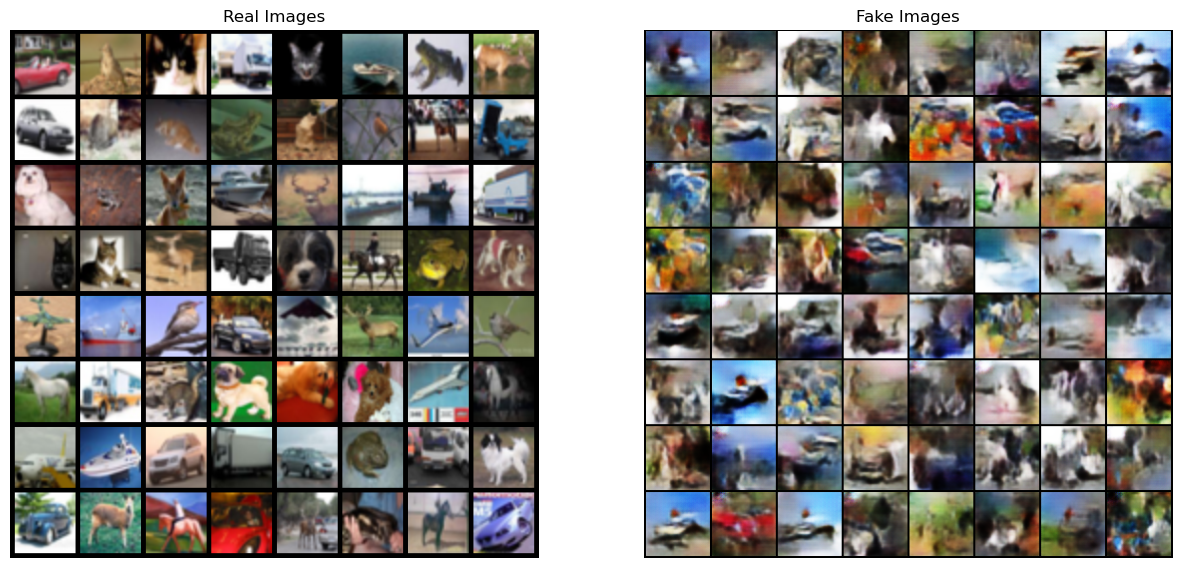

In [33]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

noise = torch.randn(BATCH_SIZE, n_z, 1, 1, device=device)
img_list = G(noise)

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[:64], padding=2, normalize=True).cpu(),(1,2,0)))